### DLib Face Detection ###

Built using [dlib](http://www.dlib.net) v18.18

dlib is a C++ library, so we need to interface with it from F#. This means we will need two wrappers for this to work: one on the managed and one on the native side. The one on the managed side will serialize the EmguCV (OpenCV wrapper) images so we can marshal them to the native side, then the native wrapper will create the dlib structures and call dlib.

In [1]:
#load "Paket.fsx"
Paket.Dependencies.Install """
frameworks: net45
source https://nuget.org/api/v2
nuget EmguCV
"""
Paket.LoadingScripts.ScriptGeneration.generateScriptsForRootFolder
   Paket.LoadingScripts.ScriptGeneration.FSharp
   (Paket.FrameworkIdentifier.DotNetFramework Paket.FrameworkVersion.V4_5)
   (System.IO.DirectoryInfo __SOURCE_DIRECTORY__)

#load "paket-files/include-scripts/net45/include.main.group.fsx"

open Emgu.CV
open Emgu.CV.CvEnum
open Emgu.CV.Util
open System
open Emgu.CV.Structure
open System.Drawing

let displayImg (img : Mat) =
        let buf = new VectorOfByte()
        CvInvoke.Imencode(".png", img, buf)
        buf.ToArray()
        |> Util.Image

### Wrap the detect function ###
See below for the source of `facedetect.dll` This is the C++ interface to dlib.

In [2]:
open System.Runtime.InteropServices

[<DllImport("facedetect.dll", EntryPoint="detect", CharSet = CharSet.Auto)>]
extern int detector(byte [] img, int [] out, int rows, int cols);


### Call the detect function ###

Calling the detect function is easy. We need to:

#### Managed code: ####

1. Serialize OpenCV structures into bytes
2. Send them to our detector

#### Native code: ####
1. Deserialize raw bytes into dlib structures
2. Invoke the detector
3. Send back the results:
  1. rectangles in the `rects` array
  2. total detected as the return value

In [3]:
let detect (frame : Mat) =

    let image : byte [] = Array.zeroCreate (frame.Rows * frame.Cols * frame.ElementSize)
    let rects : int [] = Array.zeroCreate 1000

    frame.CopyTo(image)
    let totalDetected = detector(image, rects, frame.Rows, frame.Cols)

    if totalDetected > 0 then
        rects
        |> Array.chunkBySize 4
        |> Array.take totalDetected
        |> Array.map (fun [|l; t; w; h|] -> Rectangle(l, t, w, h))
    else
        Array.empty


input.fsx(13,27): warning FS0025: Incomplete pattern matches on this expression. For example, the value '[|_; _; _; _; _|]' may indicate a case not covered by the pattern(s).

### Load an image and detect a few faces ###
We use a picture of a group of a few [admirable people](https://en.wikipedia.org/wiki/NASA_Astronaut_Group_20).

In [4]:
let imfile = "Astronaut_class_group_20.jpg"
let img = CvInvoke.Imread(imfile, LoadImageType.AnyColor)

let rects = detect img
rects

[|{X=1618,Y=165,Width=90,Height=90}; {X=444,Y=215,Width=90,Height=90};
  {X=246,Y=342,Width=108,Height=108}; {X=1399,Y=235,Width=90,Height=90};
  {X=255,Y=165,Width=90,Height=90}; {X=583,Y=404,Width=90,Height=90};
  {X=939,Y=366,Width=108,Height=108}; {X=942,Y=155,Width=90,Height=90};
  {X=1270,Y=384,Width=90,Height=90}; {X=1101,Y=245,Width=90,Height=90};
  {X=760,Y=245,Width=75,Height=75}; {X=594,Y=163,Width=75,Height=75};
  {X=1290,Y=155,Width=90,Height=90}; {X=1584,Y=377,Width=108,Height=108}|]

### Draw rectangles on the image ###

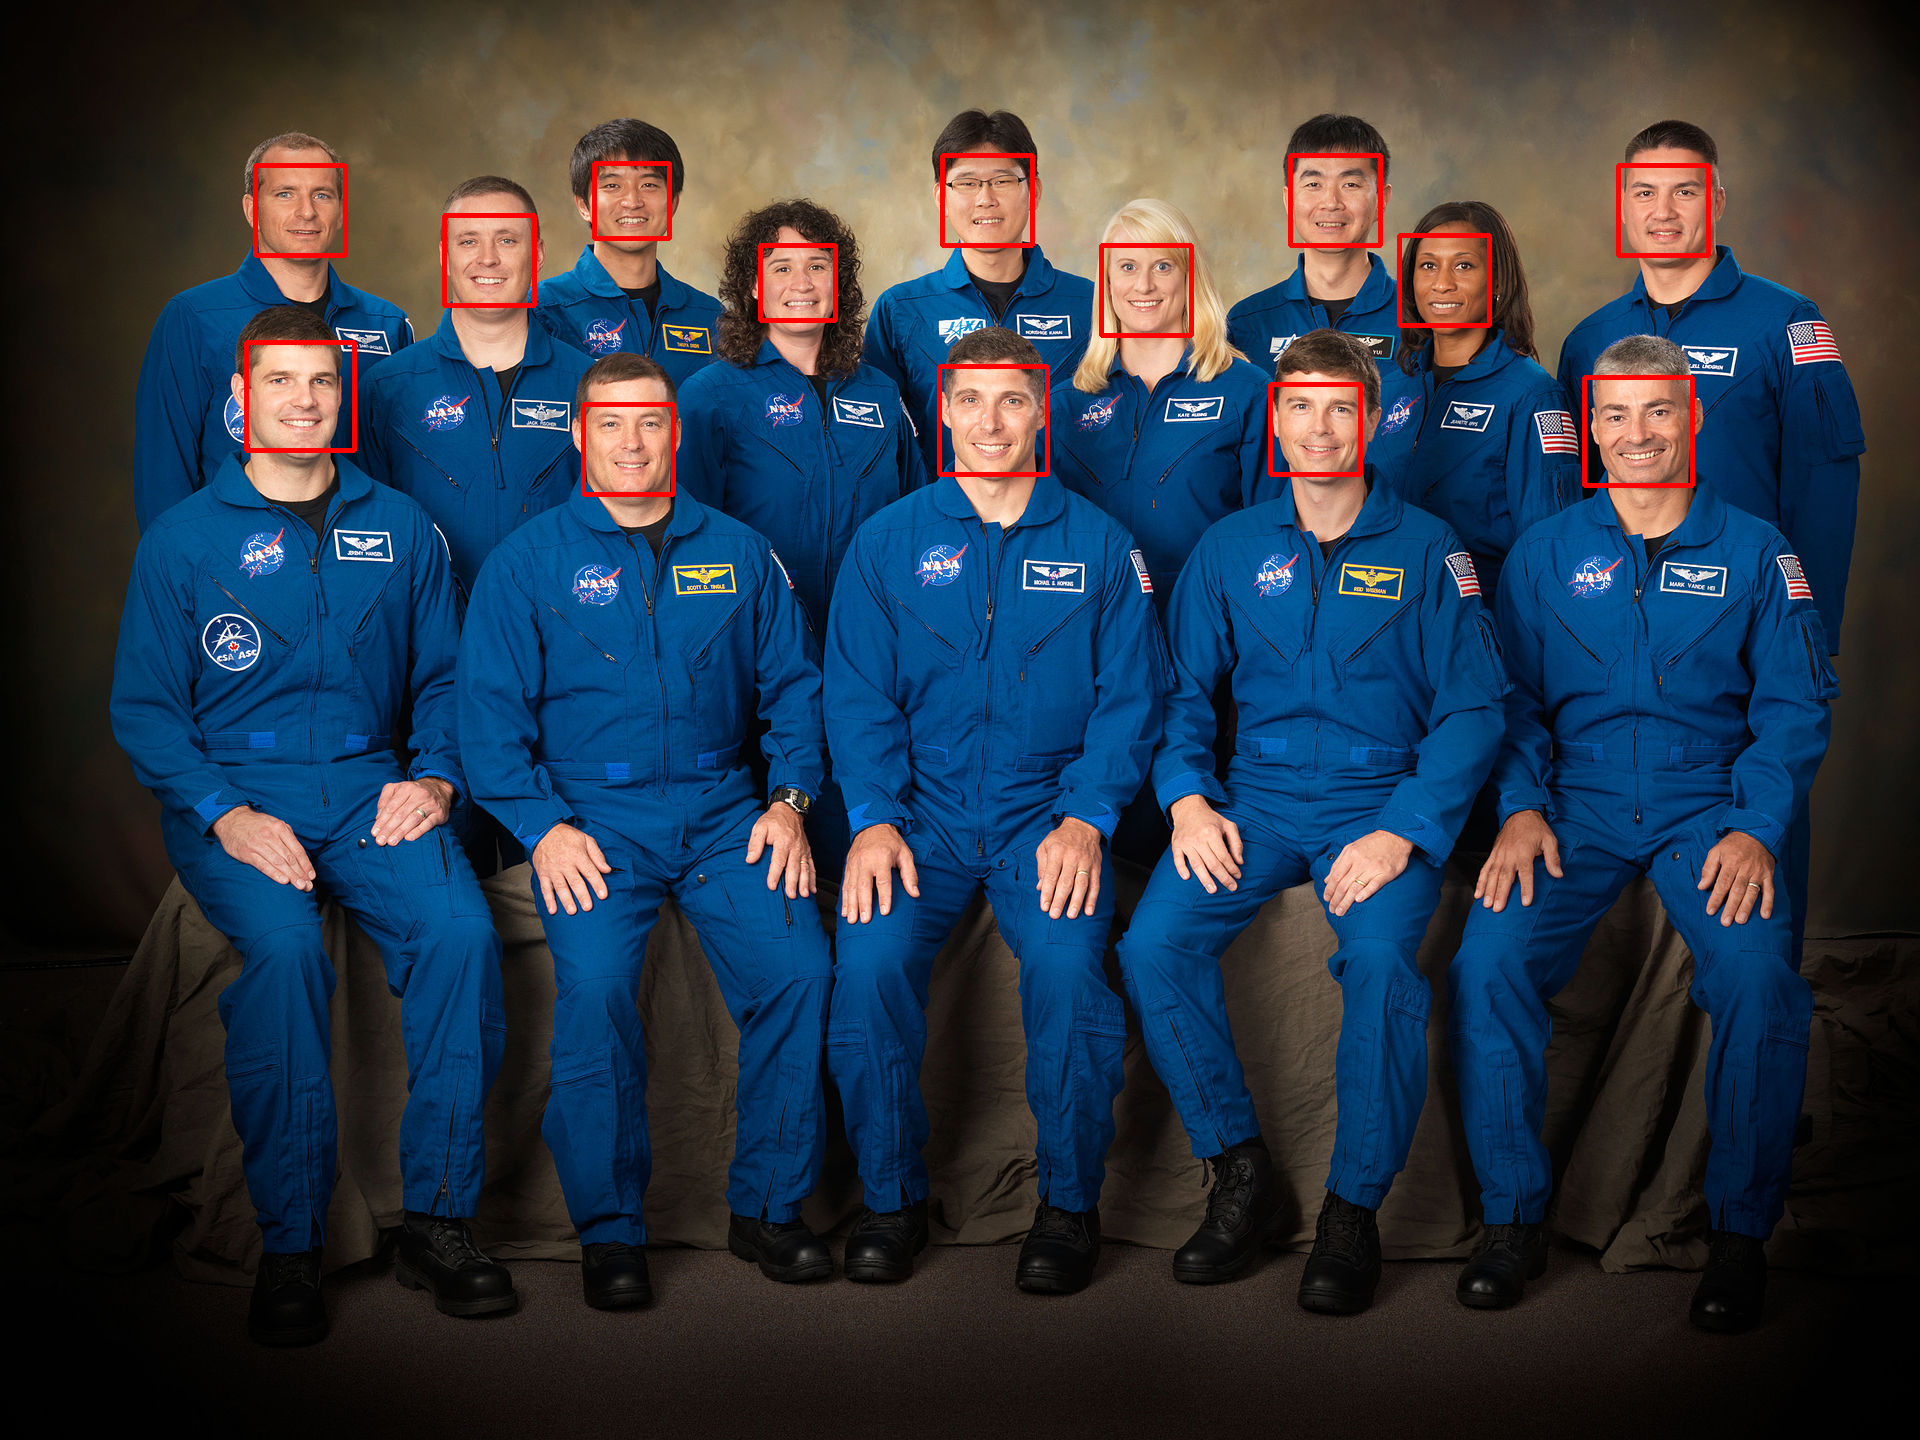

In [5]:
rects
|> Array.iter(fun r -> CvInvoke.Rectangle(img, r, Bgr(Color.Red).MCvScalar, 3))
    
displayImg img  

### Native code ###
Just what you would expect.
We go through the image bytes and (re)store them in the structure that dlib API understands. 

#### Note: ####
In the Python version of dlib there is a parameter to the detector that allows for upsizing the image before sending it to the detector. I did not find such a parameter in C++, maybe it does exist and I didn't look too carefully. In any event, I did the upsizing myself, but then the appropriate correction had to be applied to the results.

`facedetect.h`
```cpp
#ifdef FACEDETECT_EXPORTS
#define FACEDETECT_API  extern "C" __declspec(dllexport)
#else
#define FACEDETECT_API __declspec(dllimport)
#endif

FACEDETECT_API int detect(BYTE *, int *, int, int);
```

`facedetect.cpp`
```cpp
#include "facedetect.h"

#include "targetver.h"
#include <dlib/image_processing/frontal_face_detector.h>
#include <dlib/image_io.h>

FACEDETECT_API int detect(BYTE * image, int * detected, int rows, int cols)
{
    dlib::frontal_face_detector detector = dlib::get_frontal_face_detector();
    // bgr pixels come from OpenCV
    dlib::array2d<dlib::bgr_pixel> img(rows, cols);

    for (int i = 0; i < rows; i++)
    {
        for (int j = 0; j < cols; j++)
        {
            auto idxPixel = 3 * (i * cols + j);
            dlib::bgr_pixel pixel(image[idxPixel], image[idxPixel + 1], image[idxPixel + 2l]);

            img[i][j] = pixel;
        }
    }

    dlib::pyramid_up(img);
    auto rects = detector(img);

    int i = 0;
    for each (dlib::rectangle rect in rects)
    {
        detected[i++] = rect.left() / 2;
        detected[i++] = rect.top() / 2;
        detected[i++] = rect.width() / 2;
        detected[i++] = rect.height() / 2;
    }

    return (int)rects.size();
}

```